# Battery Electric Vehicle Charging

In this example a battery electric vehicle (BEV) is driven 100 km in the morning and 100 km in the evening, to simulate commuting, and charged during the day by a solar panel at the driver's place of work. The size of the panel is computed by the optimisation.

The BEV has a battery of size 100 kWh and an electricity consumption of 0.18 kWh/km.

**NB:** this example will use units of kW and kWh, unlike the PyPSA defaults

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import pypsa

%matplotlib inline

In [2]:
# use 24 hour period for consideration
index = pd.date_range("2016-01-01 00:00", "2016-01-01 23:00", freq="H")

# consumption pattern of BEV
bev_usage = pd.Series([0.0] * 7 + [9.0] * 2 + [0.0] * 8 + [9.0] * 2 + [0.0] * 5, index)

# solar PV panel generation per unit of capacity
pv_pu = pd.Series(
    [0.0] * 7
    + [0.2, 0.4, 0.6, 0.75, 0.85, 0.9, 0.85, 0.75, 0.6, 0.4, 0.2, 0.1]
    + [0.0] * 5,
    index,
)

# availability of charging - i.e. only when parked at office
charger_p_max_pu = pd.Series(0, index=index)
charger_p_max_pu["2016-01-01 09:00":"2016-01-01 16:00"] = 1.0

C:\Users\dell\AppData\Local\Temp\ipykernel_18400\2212892536.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range("2016-01-01 00:00", "2016-01-01 23:00", freq="H")


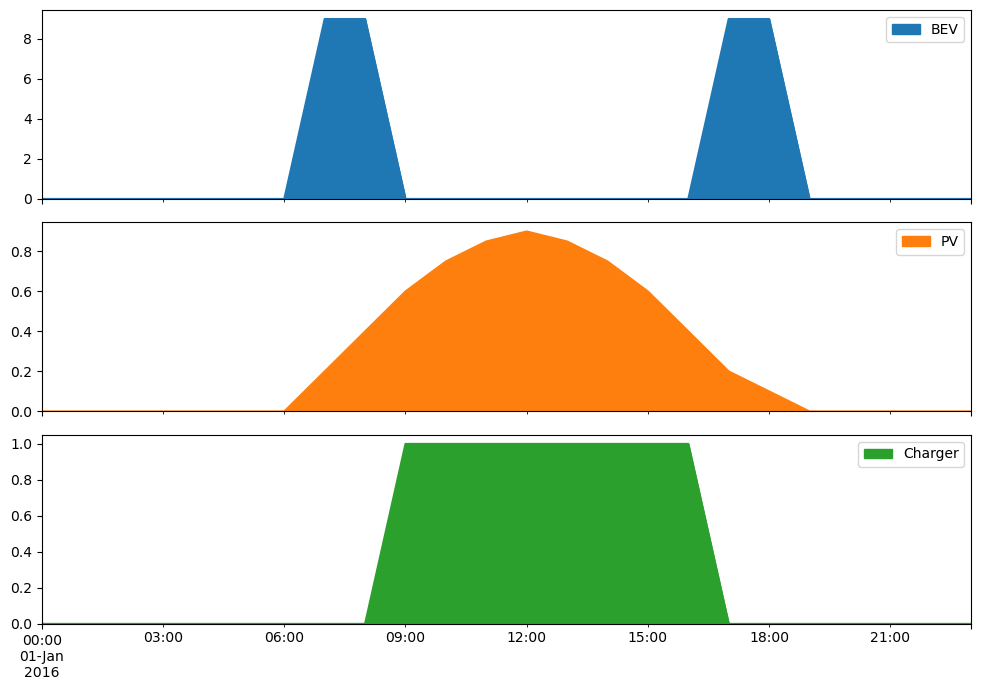

In [3]:
df = pd.concat({"BEV": bev_usage, "PV": pv_pu, "Charger": charger_p_max_pu}, axis=1)
df.plot.area(subplots=True, figsize=(10, 7))
plt.tight_layout()

Initialize the network

In [4]:
network = pypsa.Network()
network.set_snapshots(index)

network.add("Bus", "place of work", carrier="AC")

network.add("Bus", "battery", carrier="Li-ion")

network.add(
    "Generator",
    "PV panel",
    bus="place of work",
    p_nom_extendable=True,
    p_max_pu=pv_pu,
    capital_cost=1000.0,
)

network.add("Load", "driving", bus="battery", p_set=bev_usage)

network.add(
    "Link",
    "charger",
    bus0="place of work",
    bus1="battery",
    p_nom=120,  # super-charger with 120 kW
    p_max_pu=charger_p_max_pu,
    efficiency=0.9,
)


network.add("Store", "battery storage", bus="battery", e_cyclic=True, e_nom=100.0)

Index(['battery storage'], dtype='object')

In [5]:
network.optimize()
print("Objective:", network.objective)

Index(['place of work', 'battery'], dtype='object', name='Bus')
Index(['charger'], dtype='object', name='Link')
Index(['battery storage'], dtype='object', name='Store')
Index(['place of work', 'battery'], dtype='object', name='Bus')
Index(['charger'], dtype='object', name='Link')
Index(['battery storage'], dtype='object', name='Store')
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\linopy\common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.06s
INFO:linopy.solvers:Log file at C:\Users\dell\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 97 primals, 218 duals
Objective: 7.02e+03
Solver model: avail

Objective: 7017.543859649121


The optimal panel size in kW is

In [6]:
network.generators.p_nom_opt["PV panel"]

7.0175438596491215

C:\Users\dell\AppData\Local\Temp\ipykernel_20556\3243677425.py:2: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


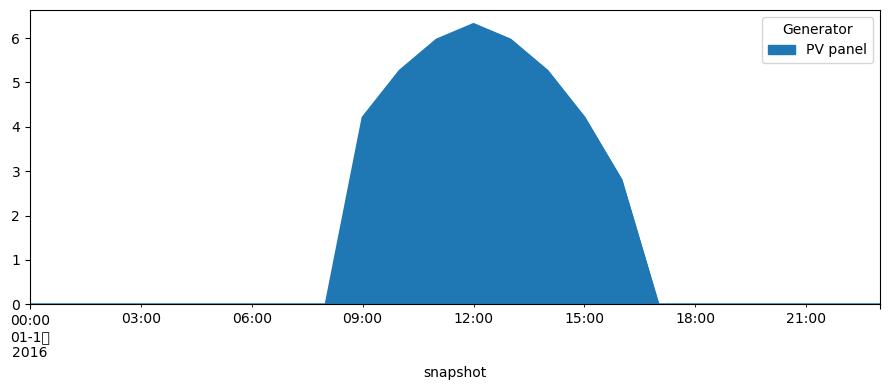

In [7]:
network.generators_t.p.plot.area(figsize=(9, 4))
plt.tight_layout()

C:\Users\dell\AppData\Local\Temp\ipykernel_20556\200718889.py:6: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


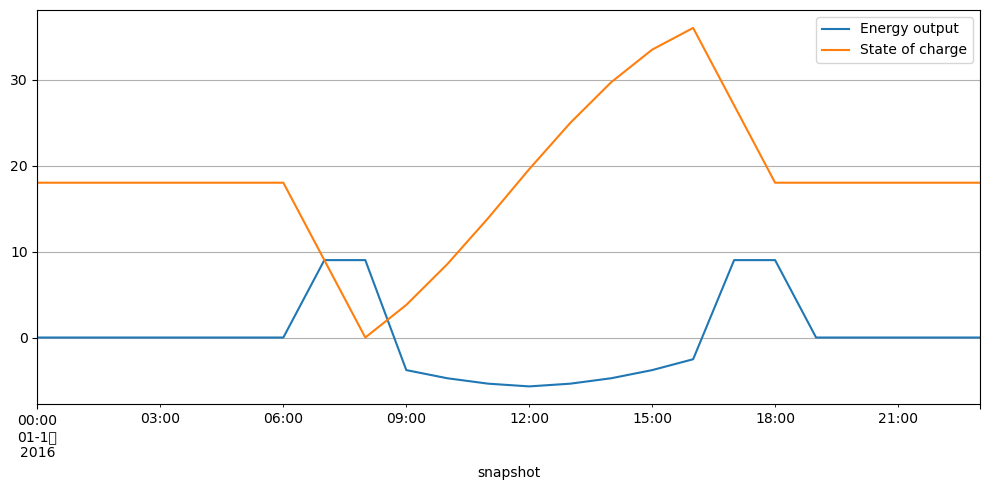

In [8]:
df = pd.DataFrame(
    {attr: network.stores_t[attr]["battery storage"] for attr in ["p", "e"]}
)
df.plot(grid=True, figsize=(10, 5))
plt.legend(labels=["Energy output", "State of charge"])
plt.tight_layout()

The losses in kWh per pay are:

In [9]:
(
    network.generators_t.p.loc[:, "PV panel"].sum()
    - network.loads_t.p.loc[:, "driving"].sum()
)

3.999999999999986

C:\Users\dell\AppData\Local\Temp\ipykernel_20556\3240579969.py:2: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


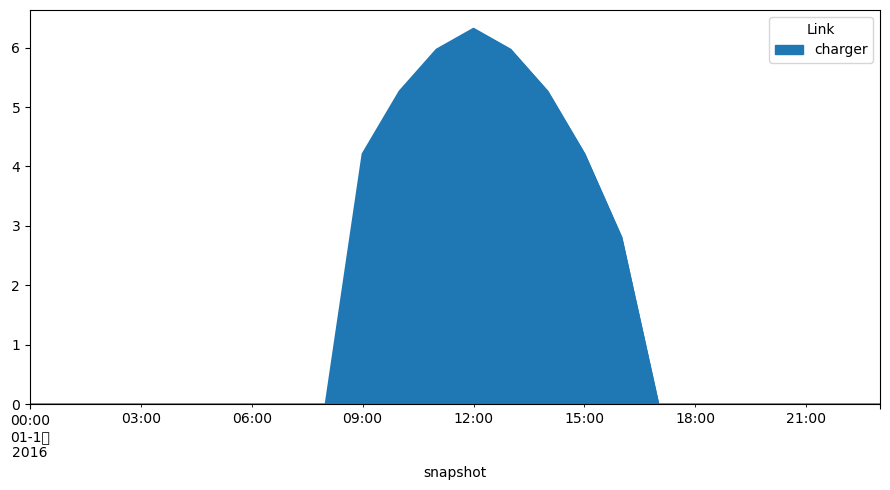

In [10]:
network.links_t.p0.plot.area(figsize=(9, 5))
plt.tight_layout()